# Segment blockface in a slide

In [1]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide

# Import wildcat
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models

# Import wildcat mods
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
!nvidia-smi

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:        0 MB
Device:  cuda:0
Wed Apr  8 14:55:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+---------------------------------------------

In [2]:
# Global properties
num_classes=2
input_size=128
input_size_wildcat=128
batch_size=16
batch_size_wildcat=16
resnet_flavor=50
fold = "fold_INDD119294"
data_dir = "/home/pyushkevich/data/bf//exp01"
model_dir="/home/pyushkevich/resnet/bf_wcat/exp01"

In [4]:
# Read the wildcat model
model_wildcat = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=1)
model_wildcat.load_state_dict(torch.load(os.path.join(model_dir, "bf_wcat_50_30epoch_k02_upsample_1map.dat")))

# Set evaluation mode
model_wildcat.eval()

# Send model to GPU
model_wildcat = model_wildcat.to(device)

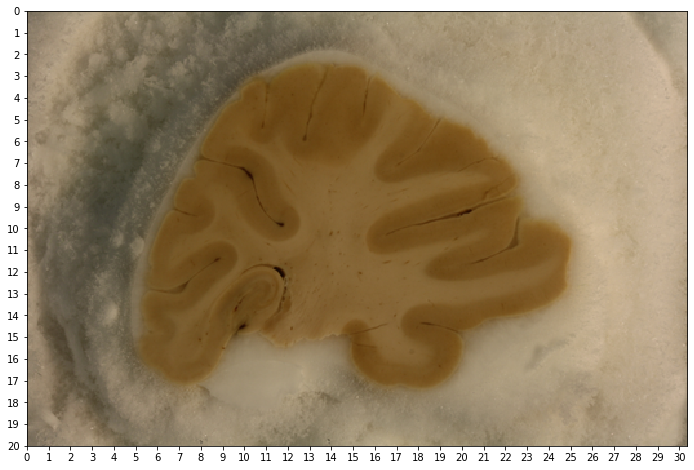

In [5]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide('/home/pyushkevich/data/bf/raw_slides/HNL-35-18_HR3a_25_07_pyramidal.tiff')
plt.figure(figsize=(16,8))
plt.imshow(osl.get_thumbnail((512,512)), extent=(0,osl.level_dimensions[0][0]/128,osl.level_dimensions[0][1]/128,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/128));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/128));

In [6]:
# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 128

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 1024

# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
padding_size_rel = 1.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=2

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=4

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size_wildcat

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((2, out_dim[0], out_dim[1]))

# Range of pixels to scan
#u_range,v_range = (5,19),(19,31)
u_range,v_range = (0,n_win[0]),(0,n_win[1])

# Range non-overlapping windows
t_00 = timeit.default_timer()
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp,wp = x-padding_size_raw,y-padding_size_raw,window_size_raw+2*padding_size_raw
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")
        t1 = timeit.default_timer()
                
        # Compute the desired size of input to wildcat
        wwc = int(wp * input_size_wildcat / patch_size_raw)

        # Resample the chunk for the two networks
        tran = transforms.Compose([
            transforms.Resize((wwc,wwc)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Convert the read chunk to tensor format
        with torch.no_grad():
            
            # Apply transforms and turn into correct-size torch tensor
            chunk_tensor=torch.unsqueeze(tran(chunk_img),dim=0).to(device)
            
            # Forward pass through the wildcat model
            x_clas = model_wildcat.forward_to_classifier(chunk_tensor)
            x_cpool = model_wildcat.spatial_pooling.class_wise(x_clas)

            # Scale the cpool image to desired size
            x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

            # Extract the central portion of the output
            p0,p1 = padding_size_out,(padding_size_out+window_size_out)
            x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]
            
            # Stick it into the output array
            xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
            yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
            density[0,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,0,:,:].transpose()
            density[1,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,1,:,:].transpose()
                
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Chunk: (     0,     0) Times: IO=0.0881 WldC=0.2291 Totl=  0.3172
Chunk: (     0,     1) Times: IO=0.0852 WldC=0.2148 Totl=  0.3000
Chunk: (     0,     2) Times: IO=0.0461 WldC=0.2149 Totl=  0.2610
Chunk: (     1,     0) Times: IO=0.0811 WldC=0.2144 Totl=  0.2954
Chunk: (     1,     1) Times: IO=0.0822 WldC=0.2145 Totl=  0.2967
Chunk: (     1,     2) Times: IO=0.0451 WldC=0.2141 Totl=  0.2591
Chunk: (     2,     0) Times: IO=0.0860 WldC=0.2149 Totl=  0.3009
Chunk: (     2,     1) Times: IO=0.0814 WldC=0.2143 Totl=  0.2957
Chunk: (     2,     2) Times: IO=0.0451 WldC=0.2139 Totl=  0.2590
Chunk: (     3,     0) Times: IO=0.0618 WldC=0.2145 Totl=  0.2763
Chunk: (     3,     1) Times: IO=0.0670 WldC=0.2146 Totl=  0.2816
Chunk: (     3,     2) Times: IO=0.0400 WldC=0.2151 Totl=  0.2550


In [7]:
# Compute the default v_range
v_range_def = (-12,12)

# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,vrange=v_range_def):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    t_map=np.where(t_map > 0, t_map, 0)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    # ax[1].colorbar(cs)
    fig.show()

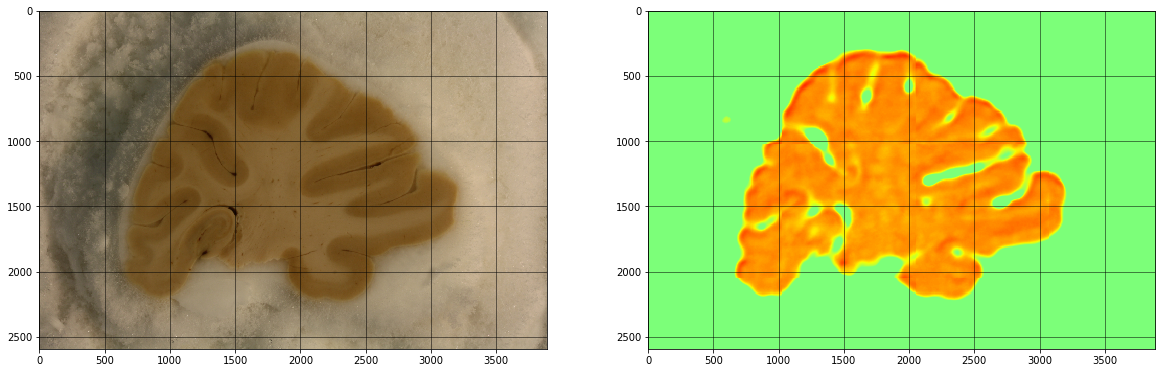

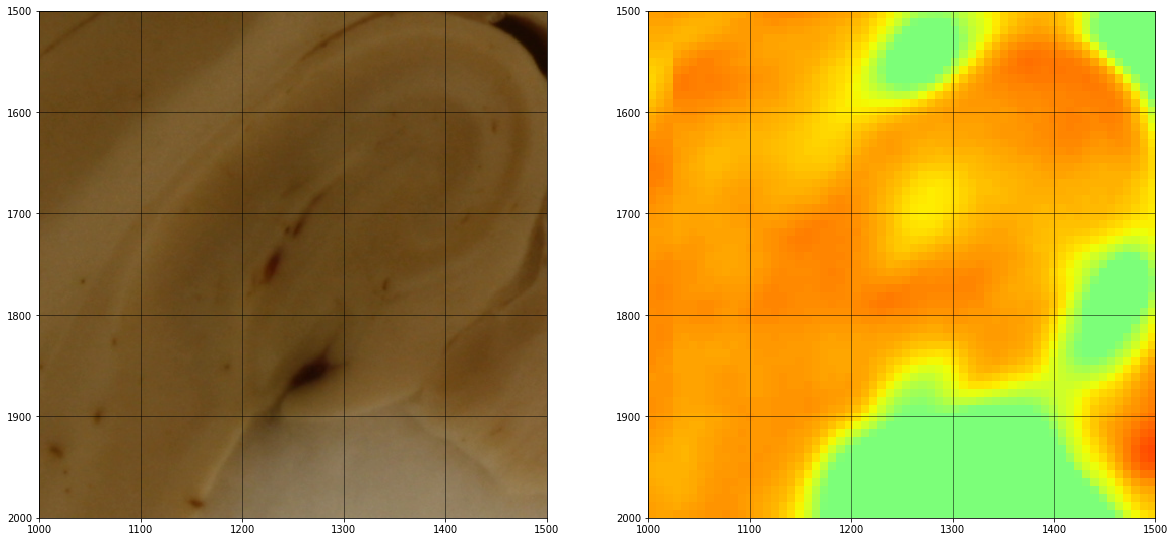

In [8]:
plot_classification_region(0,0,slide_dim[0],slide_dim[1],1)
plot_classification_region(1000,1500,1500,2000,0)

In [9]:
# Just run on the whole image in one go
bf_whole=osl.read_region((0,0), 0, slide_dim).convert("RGB")

# Simple transform
tran_whole = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Convert the read chunk to tensor format
with torch.no_grad():

    # Apply transforms and turn into correct-size torch tensor
    whole_tensor=torch.unsqueeze(tran_whole(bf_whole),dim=0).to(device)

    # Forward pass through the wildcat model
    x_clas = model_wildcat.forward_to_classifier(whole_tensor)
    x_cpool = model_wildcat.spatial_pooling.class_wise(x_clas)
    x_spat = model_wildcat.spatial_pooling.spatial(x_cpool)
    
    # Get the complete output
    x_final = model_wildcat(whole_tensor)

In [10]:
slide_dim, x_cpool.size(),x_final.size(),x_clas.size(),x_spat.size()

(array([3888, 2592]),
 torch.Size([1, 2, 1296, 1944]),
 torch.Size([1, 2]),
 torch.Size([1, 2, 1296, 1944]),
 torch.Size([1, 2]))

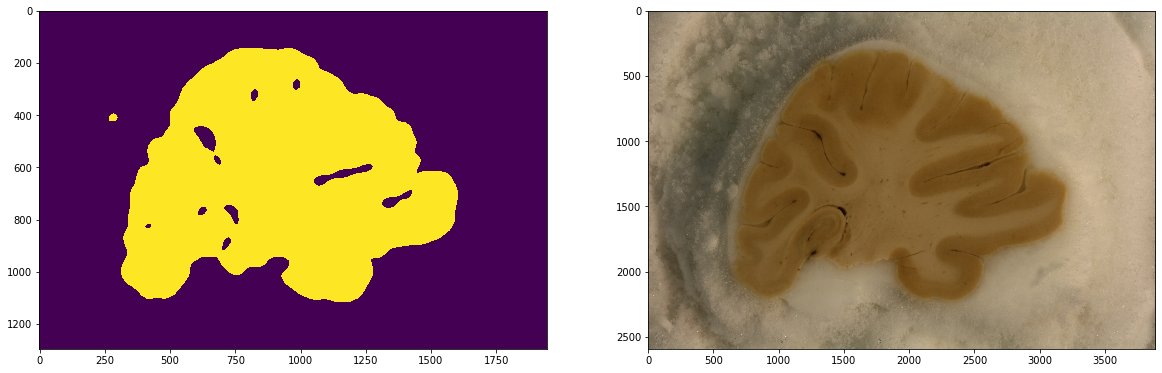

In [13]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
p0 = x_cpool[0,0,:,:].detach().cpu().numpy()
p1 = x_cpool[0,1,:,:].detach().cpu().numpy()
ax[0].imshow(p1-p0 > 0)
ax[1].imshow(bf_whole)

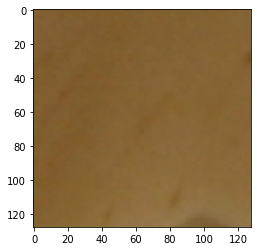

In [16]:
test_rgn = osl.read_region((1700,1780),0,(128,128)).convert("RGB")
plt.imshow(test_rgn)

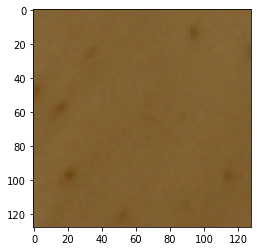

In [17]:
test_rgn_2 = osl.read_region((1700,1580),0,(128,128)).convert("RGB")
plt.imshow(test_rgn_2)

In [19]:
# Apply transforms and turn into correct-size torch tensor
bf_whole=osl.read_region((0,0), 0, slide_dim).convert("RGB")

# Simple transform
tran_whole = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

whole_tensor=torch.unsqueeze(tran_whole(bf_whole),dim=0).to(device)
P=whole_tensor.unfold(3, 128, 64).unfold(2, 128, 64)
P.shape

torch.Size([1, 3, 39, 59, 128, 128])

In [20]:
P1=P.permute(0,2,3,1,4,5).contiguous().view(-1,3,128,128)
P1.shape

torch.Size([2301, 3, 128, 128])

In [21]:
P1.shape[0]

2301

In [22]:
z = torch.zeros(2,P1.shape[0])
for k in range(0,P1.shape[0],200):
    n=min(k+200,P1.shape[0])
    batch=P1[k:n,:,:,:]
    print(k)
    with torch.no_grad():
        z[0,k:n]=model_wildcat(batch).detach().cpu()[:,0]
        z[1,k:n]=model_wildcat(batch).detach().cpu()[:,1]

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200


In [23]:
z.shape

torch.Size([2, 2301])

In [24]:
z2d=z.view(2, 39, 59)

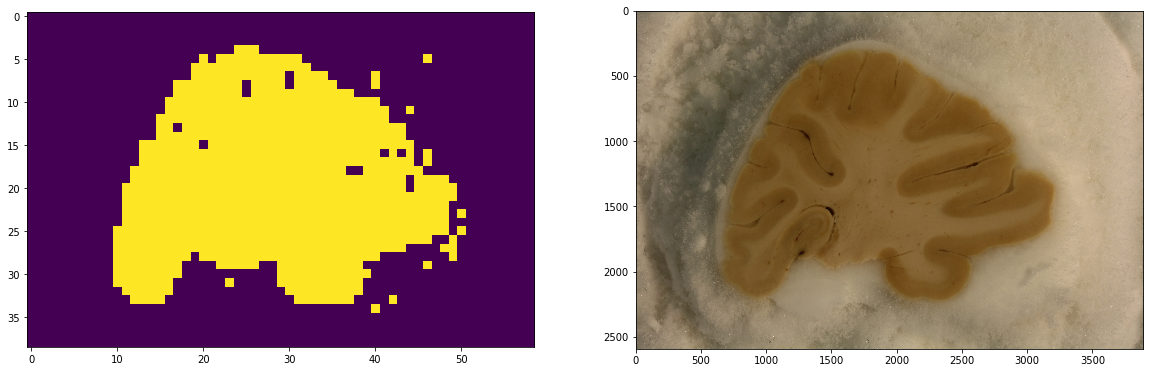

In [25]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
p0 = x_cpool[0,0,:,:].detach().cpu().numpy()
p1 = x_cpool[0,1,:,:].detach().cpu().numpy()
ax[0].imshow(z2d[0,:,:] < z2d[1,:,:])
ax[1].imshow(bf_whole)